In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

# Diseño para un motor de continua

Supongamos que la transferencia de nuestro sistema es:

$$G(s)=\frac{10}{s(s+2)(s+8)}$$

Diseño un controlador que ubique los polos en:

$$pc=[-1.42;\quad -1.04\pm2.14j]$$

y los del estimador tres veces más rápidos.

Como tenemos el sistema en forma de función transferencia lo llevamos a alguna forma en espacio de estados (la que sea por defecto de Python)

In [2]:
G=ctrl.tf(10,[1,10,16,0])
G

TransferFunction(array([10]), array([ 1, 10, 16,  0]))

## Expresión en variables de estado

De las formas canónicas disponibles, elegimos la forma canónica de observabilidad.

In [3]:
ctrl.canonical_form?

In [4]:
sys,_=ctrl.canonical_form(ctrl.ss(G),'observable')
sys

StateSpace(array([[-10.,   1.,   0.],
       [-16.,   0.,   1.],
       [ -0.,   0.,   0.]]), array([[ 0.],
       [ 0.],
       [10.]]), array([[1., 0., 0.]]), array([[0.]]))

## Ley de control y estimador completo

In [5]:
pc=np.array([-1.42, -1.04+2.14j,-1.04-2.14j])
pe = pc*3

Notar que hubiera podido escribir pc como una lista de los valores en donde quiero ubicar los polos a lazo cerrado. Sin embargo, luego no hubiera podido hacer la operación de `pc*3` sobre la lista, ya que hubiera resultado en algo que no es lo que buscábamos.

**Obtenemos la ley de control:**

In [6]:
K=ctrl.place(sys.A,sys.B,pc)

**Obtenemos L del estimador:**

In [7]:
L=ctrl.place(sys.A.T,sys.C.T,pe).T

Hemos podido utilizar el comando `place` debido a que los 3 polos tanto del estimador como de los elegidos para la ley de control son distintos. De haber querido ubicar dos polos en el mismo lugar, hubiéramos tenido que usar el comando `acker`.

Sin embargo es necesario tener en cuenta que `acker` no es recomendable para sistema de orden mayor a 4.

### Sistema controlador con estimador completo

In [8]:
Dc=ctrl.ss(sys.A-sys.B@K-L@sys.C,L,-K,0)
ctrl.tf(Dc)
ctrl.isctime(Dc)

True

In [9]:
Dc.pole()

array([-2.93739746+8.32368499j, -2.93739746-8.32368499j,
        1.87479491+0.j        ])

Podemos ver que el controlador diseñado es inestable!. Esto no es deseable.

La razones por la que no es deseable un controlador inestable  son:

1. Presenta dificultades para ser testeado, ya sea el compensador por si solo o en lazo abierto durante la puesta en funcionamiento. Sin embargo, en algunos casos, se puede lograr una mejor performance del sistema de controlado con un controlador inestable (hay casos de sistemas que ni siquiera pueden ser estabilizados con controladores estables.). En ese caso se aceptan estos inconvenientes de testeo.

2. Para ganancias bajas el sistema a lazo cerrado con un controlador inestable resulta inestable (visualizar el root locus). En general, los actuadores presentan saturaciones, es decir valor máximos de actuación. Cuando un actuador satura se ve desde el punto de vista de lazo como una reducción de la ganancia, llevando a la zona instable o acercándose a la misma.

Los sistemas que necesitan se vuelven inestables cuando su valor ganancia se reduce se los conoce como sistemas **condicionalmente estables** y **deben ser evitados** en la medida de lo posible.

## Rediseñamos usando un estimador reducido

Ahora pondremos los polos tal que $\omega_n=6$ rad/seg y $\zeta=0.707$

In [10]:
pe_red= np.roots([1,2*0.707*6,6**2])
pe_red

array([-4.242+4.24328128j, -4.242-4.24328128j])

Necesitamos las sub-matrices de A para calcular el estimadores reducido

In [11]:
Aaa=sys.A[0:1,0:1]
Aab=sys.A[0:1,1:]
Aba=sys.A[1:,0:1]
Abb=sys.A[1:,1:]

Ba = sys.B[0:1,0:]
Bb = sys.B[1:,0:]

Ahora calculemos el estimador reducido.

In [12]:
Ltred = ctrl.place(Abb.T,Aab.T,pe_red).T
Ltred

array([[ 8.484],
       [36.   ]])

### Sistema controlador con estimador reducido

In [13]:
Ka=K[0:1,0:1]
Kb=K[0:1,1:]

Ar = Abb-Ltred@Aab-(Bb-Ltred@Ba)@Kb
Br = Ar@Ltred + Aba - Ltred@Aaa - (Bb-Ltred@Ba)@Ka
Cr = -Kb
Dr = -Ka-Kb@Ltred

In [14]:
Dcr = ctrl.ss(Ar,Br,Cr,Dr)
Dcr

StateSpace(array([[ -8.484 ,   1.    ],
       [-93.6148,   6.5   ]]), array([[ 32.861744 ],
       [263.8811328]]), array([[-5.76148,  0.65   ]]), array([[20.93051328]]))

In [15]:
ctrl.tf(Dcr)

TransferFunction(array([ 20.93051328,  23.71659385, -28.9400544 ]), array([ 1.    ,  1.984 , 38.4688]))

In [16]:
Dcr.pole()

array([-0.992+6.12247793j, -0.992-6.12247793j])

In [17]:
Dcr.zero()

array([ 0.73868705+0.j, -1.871798  +0.j])

Si bien este diseño mejoró al anterior ya que el controlador resultante es estable, este presenta un problema potencialmente menos danino. El problema es que es un controlador de no mínima fase, ya que tiene un 0 en el lado derecho del plano $s$, limitando la velocidad del sistema controlado.

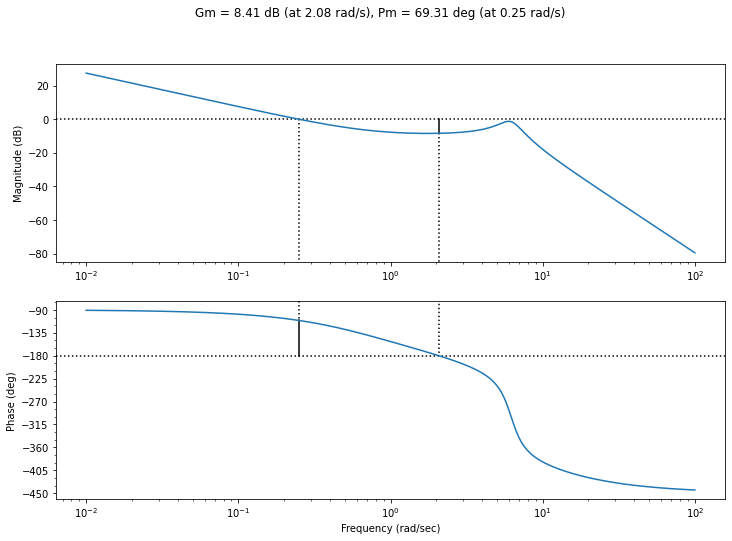

In [18]:
L=-ctrl.tf(Dcr)*G/ctrl.db2mag(6)
ctrl.bode(L,dB=True, margins=True, omega_num=2000);
plt.gcf().set_size_inches(12,8)

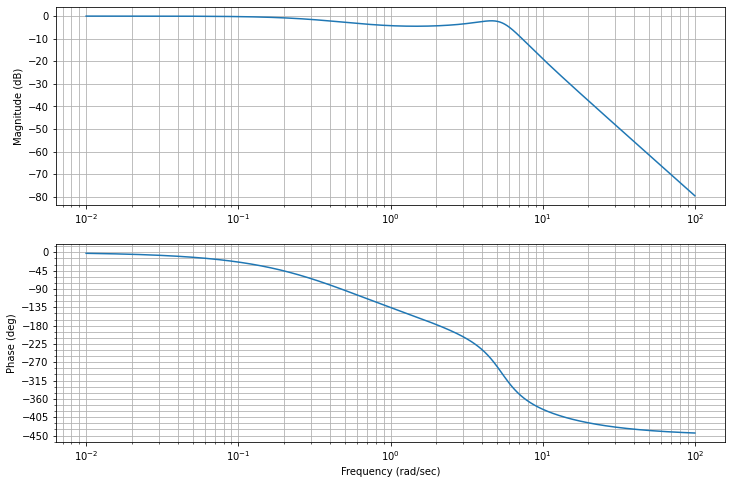

In [19]:
T=ctrl.feedback(L)
plt.figure()
ctrl.bode(T,dB=True);
plt.gcf().set_size_inches(12,8)

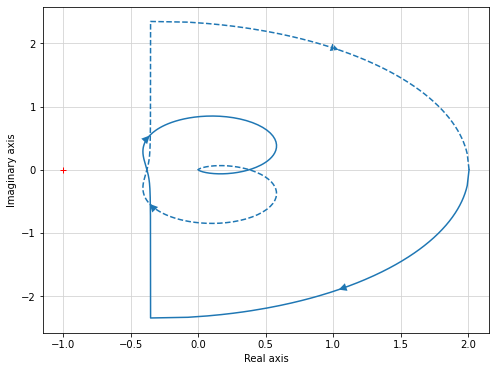

In [20]:
_=ctrl.nyquist(L);
plt.gcf().set_size_inches(8,6)

Agregamos referencia al controlador de orden reducido.

In [21]:
def seguimiento_referencia(sys):
    aux1=np.vstack((np.hstack((sys.A,sys.B)),
                   np.hstack((sys.C,sys.D))))
    n=np.shape(sys.A)[0]
    aux2=np.vstack((np.zeros((n,1)),[1]))
    N=np.linalg.inv(aux1)@aux2
    Nx=N[0:n]
    Nu=N[n]
    return Nx, Nu

def calculate_Nbar(Nx,Nu,K):
    return Nu+K@Nx

In [22]:
Nx, Nu = seguimiento_referencia(sys)
Nbar = calculate_Nbar(Nx,Nu, K)
Nbar

array([[0.8038904]])

In [23]:
N=Nbar # Lo vemos mañana como se saca
M=(Bb-Ltred@Ba)*N
M

array([[0.      ],
       [8.038904]])

In [24]:
Dcr_ref = ctrl.ss(Ar, np.hstack((Br,M)), Cr, np.hstack((Dr,N)))
Dcr_ref

StateSpace(array([[ -8.484 ,   1.    ],
       [-93.6148,   6.5   ]]), array([[ 32.861744 ,   0.       ],
       [263.8811328,   8.038904 ]]), array([[-5.76148,  0.65   ]]), array([[20.93051328,  0.8038904 ]]))

## Rediseño usando SRL

Vamos a diseñar el sistema para ubicar los polos de forma tal que se tenga un ancho de banda de 2.5rad/seg y que los polos del estimador estén aproximadamente 2.5 veces más rápido.

Para usar SRL vamos a tomar que $\mathbf{C} = \mathbf{C_1}$ y que $\mathbf{B} = \mathbf{B_1}$

In [25]:
def conjugate_tf(G):
    num = ctrl.tf(G).num[0][0]
    den = ctrl.tf(G).den[0][0]
    nume = [num[i]*((-1)**(len(num)%2+1-i)) for i in range(0, len(num))]
    dene = [den[i]*((-1)**(len(den)%2+1-i)) for i in range(0, len(den))]
    return ctrl.tf(nume,dene)

In [26]:
Gm=conjugate_tf(G)
Gm

TransferFunction(array([10]), array([ -1.,  10., -16.,   0.]))

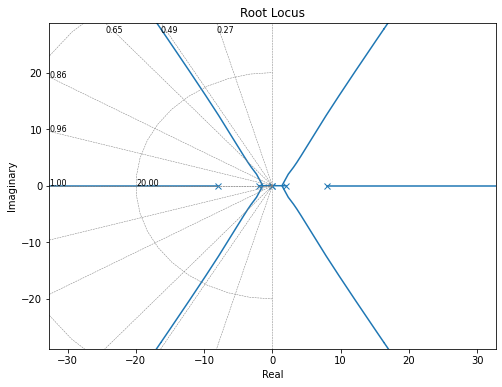

In [27]:
_=ctrl.rlocus(G*Gm)
plt.gcf().set_size_inches(8,6)

Con $K=26$ obtenemos los polos con una frecuencia de corte de 2.5 rad/seg.

In [28]:
pc,_=ctrl.rlocus(G*conjugate_tf(G),kvect=[26],Plot=False)
pc = pc[pc.real<0]
pc

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/control/rlocus.py:121: FutureWarning: 'Plot' keyword is deprecated in root_locus; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in root_locus; "


array([-8.04131959+0.j        , -2.00120126-1.52846879j,
       -2.00120126+1.52846879j])

Y con K=1350 tenemos los polos del estimador.

In [29]:
pe,_=ctrl.rlocus(G*conjugate_tf(G),kvect=[1350],Plot=False)
pe = pe[pe.real<0]
pe

array([-9.16842047+0.j        , -4.00280684-4.90432763j,
       -4.00280684+4.90432763j])

In [30]:
print("Polos de la ley de control: ",pc)
print("Polos del estimador: ",pe)

Polos de la ley de control:  [-8.04131959+0.j         -2.00120126-1.52846879j -2.00120126+1.52846879j]
Polos del estimador:  [-9.16842047+0.j         -4.00280684-4.90432763j -4.00280684+4.90432763j]


In [31]:
K=ctrl.place(sys.A,sys.B,pc)
L=ctrl.place(sys.A.T,sys.C.T,pe).T

In [32]:
Dcsrl=ctrl.ss(sys.A-sys.B@K-L@sys.C,L,-K,0)
ctrl.tf(Dcsrl)

TransferFunction(array([  -93.58707346,  -981.95825666, -1873.49939952]), array([  1.        ,  19.21775626, 150.66107776, 632.60511522]))

In [33]:
Dcsrl.pole()

array([-10.64805029+0.j        ,  -4.28485298+6.40706271j,
        -4.28485298-6.40706271j])

In [34]:
Dcsrl.zero()

array([-2.04830455e+17+0.j, -7.98559378e+00+0.j, -2.50686229e+00+0.j])

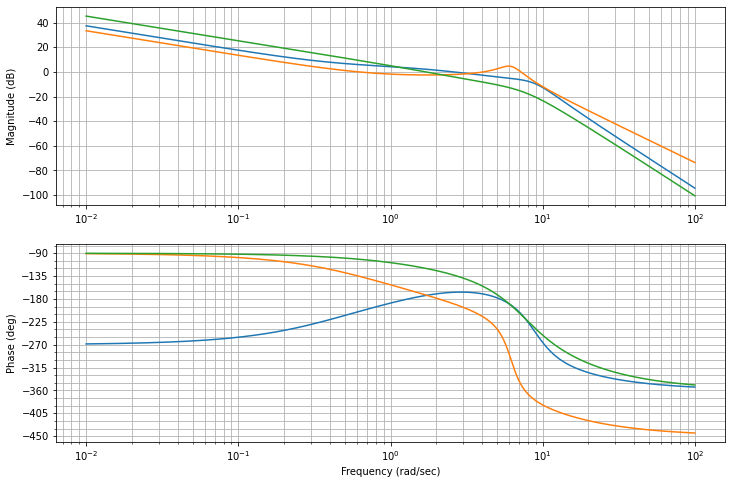

In [35]:
_=ctrl.bode((-sys*Dc,-sys*Dcr,-sys*Dcsrl),omega_limits=(1e-2,1e2),dB=True)
plt.gcf().set_size_inches(12,8)

In [36]:
print(ctrl.margin(-sys*Dc))
print(ctrl.margin(-sys*Dcr))
print(ctrl.margin(-sys*Dcsrl))

(0.6817283208674022, 13.183302483780267, 1.3027826533899076, 2.608292172554142)
(1.3198762960800359, -35.20865106169404, 2.0788986358803316, 4.058211662618327)
(3.7818445925935746, 60.09561708471924, 5.497487495572731, 1.7117848527162454)


In [37]:
T1=ctrl.feedback(-sys*Dc)
T2=ctrl.feedback(-sys*Dcr)
T3=ctrl.feedback(-sys*Dcsrl)

In [38]:
print(f"Los polos de T1 son: {T1.pole()}")
print(f"Los polos de T2 son: {T2.pole()}")
print(f"Los polos de T3 son: {T3.pole()}")

Los polos de T1 son: [-3.12+6.42j -3.12-6.42j -1.04+2.14j -1.04-2.14j -1.42+0.j   -4.26+0.j  ]
Los polos de T2 son: [-4.242+4.24328128j -4.242-4.24328128j -1.04 +2.14j
 -1.04 -2.14j       -1.42 +0.j        ]
Los polos de T3 son: [-9.16842047+0.j         -8.04131959+0.j         -4.00280684+4.90432763j
 -4.00280684-4.90432763j -2.00120126+1.52846879j -2.00120126-1.52846879j]


### Respuesta al escalón del sistema "controlado" (a partir de una salida distinta de 0)

In [39]:
t1,y1 = ctrl.initial_response(T1, X0=np.matrix([0,0,0,-1,0,0]).T,T=np.linspace(0,5,1000))
t2,y2 = ctrl.initial_response(T2, X0=np.matrix([0,0,-1,0,0]).T,T=np.linspace(0,5,1000))
t3,y3 = ctrl.initial_response(T3, X0=np.matrix([0,0,0,-1,0,0]).T,T=np.linspace(0,5,1000))

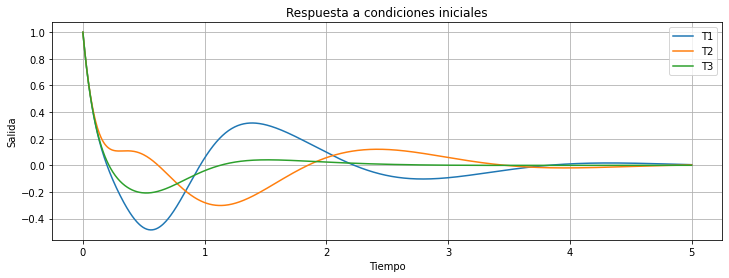

In [40]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t1,y1,label="T1")
ax.plot(t2,y2,label="T2")
ax.plot(t3,y3,label="T3")
plt.legend()
ax.set_title('Respuesta a condiciones iniciales')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Salida")
ax.grid()

## Conexión de sistemas entrada/salida

Podemos ver en el caso anterior que mediante el uso de la función ctrl.feedback hemos perdido, al menos parcialmente, saber de que manera están ordenados los estados del sistema.

Par aun mayor control de como están ubicados los estados, las entradas y la salidas es conveniente usar la función `ctrl.append` y `ctrl.connect`.

In [41]:
ctrl.connect?

In [42]:
sys_conectado_1 = ctrl.connect(ctrl.append(sys,Dc),
                               [[1,2],[2,1]],[1],[1,2])
sys_conectado_1

StateSpace(array([[-10.      ,   1.      ,   0.      ,   0.      ,   0.      ,
          0.      ],
       [-16.      ,   0.      ,   1.      ,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , 464.109096, -57.6148  ,
          6.5     ],
       [  0.5     ,   0.      ,   0.      , -10.5     ,   1.      ,
          0.      ],
       [ 61.5332  ,   0.      ,   0.      , -77.5332  ,   0.      ,
          1.      ],
       [217.050408,   0.      ,   0.      , 247.058688, -57.6148  ,
          6.5     ]]), array([[ 0.],
       [ 0.],
       [10.],
       [ 0.],
       [ 0.],
       [ 0.]]), array([[ 1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , 46.4109096, -5.76148  ,
         0.65     ]]), array([[0.],
       [0.]]))

In [43]:
sys_conectado_2 = ctrl.connect(ctrl.append(sys,Dcr),[[1,2],[2,1]],[1],[1,2])
sys_conectado_2

StateSpace(array([[-10.       ,   1.       ,   0.       ,   0.       ,   0.       ],
       [-16.       ,   0.       ,   1.       ,   0.       ,   0.       ],
       [209.3051328,   0.       ,   0.       , -57.6148   ,   6.5      ],
       [ 32.861744 ,   0.       ,   0.       ,  -8.484    ,   1.       ],
       [263.8811328,   0.       ,   0.       , -93.6148   ,   6.5      ]]), array([[ 0.],
       [ 0.],
       [10.],
       [ 0.],
       [ 0.]]), array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [20.93051328,  0.        ,  0.        , -5.76148   ,  0.65      ]]), array([[0.],
       [0.]]))

In [44]:
sys_conectado_3 = ctrl.connect(ctrl.append(sys, Dcsrl), [[1,2], [2,1]], [1], [1,2])
sys_conectado_3

StateSpace(array([[ -10.        ,    1.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [ -16.        ,    0.        ,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    2.59335883,
          -2.08840003,   -2.04372211],
       [   7.17403415,    0.        ,    0.        ,  -17.17403415,
           1.        ,    0.        ],
       [  97.47372448,    0.        ,    0.        , -113.47372448,
           0.        ,    1.        ],
       [ 367.42346142,    0.        ,    0.        , -364.83010259,
          -2.08840003,   -2.04372211]]), array([[ 0.],
       [ 0.],
       [10.],
       [ 0.],
       [ 0.],
       [ 0.]]), array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.25933588, -0.20884   ,
        -0.20437221]]), array([[0.],
       [0.]]))

La manera en que `ctrl.connect` trabaja es:

1. El primer argumento es un sistema de muchas entradas y muchas salidas que se tienen que interconectar. Para esto, agrupamos todos los sistemas que queremos interconectar mediante la función `ctrl.append`. Esta función nos va a devolver un único sistema en general de muchas entradas y muchas salidas.

2. El segundo argumento es una matriz de interconexión, donde cada fila nos dice que entrada se conecta con que salida. Las entradas y las salidas quedan ordenadas según el orden que hayamos puesto en la función `ctrl.append`, y están númeradas a partir de 1.

3. El tercer argumento, nos dice que entradas van a ser tomadas como entradas del sistema.

4. El cuarto y último argumento son las salidas del sistema.

Revisemos la utilización de `ctrl.connect` en nuestro ejemplo:

1. El primer argumento es un sistema construído a partir de `ctrl.append` que incluye a `sys` (la planta que queremos controlar) y a `Dc` (el controlador). Esta función nos va a devolver un sistema cuyos primeros 3 estados serán los estados de `sys` y los restantes son los del observador; tendrá dos donde la primer entrada es la de `sys` y la segunda entrada es la de `Dc`; y la primer salida es la de `sys` y la segunda salida es la de `Dc`.

2. El segundo argumento es la matriz de interconexión. Primero conecto la entrada de `sys` con la salida de `Dc`. Como `sys` en `ctrl.append` está primero, la entrada 1 corresponde a la de `sys` y la salida 2 corresponde a la salida de `Dc`. De esta manera tenemos la primer fila de `Q`. La segunda fila de `Q` conecta la entrada de `Dc` con la salida de `sys`.

3. El sistema que estamos generando no tiene entradas, pero el módulo de control tiene algunos problemas en sistemas que no tienen entradas o que no tiene salidas, por eso el tercer argumento vamos a poner [1], que significa una entrada que se sumará a la salida de `Dc` en la entrada de `sys`.

4. El último argumento son las salidas. Voy a tomar como salidas de mi sistema el esfuerzo de control, es decir la salida del sistema `Dc`, y la salida de la planta, es decir la salida de `sys`.

Vamos a realizar nuevamente las simulaciones con los sistemas definidos mediante el connect.

In [45]:
t1,y1 = ctrl.initial_response(sys_conectado_1, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))
t2,y2 = ctrl.initial_response(sys_conectado_2, X0=np.matrix([1,0,0,0,0]).T,T=np.linspace(0,5,1000))
t3,y3 = ctrl.initial_response(sys_conectado_3, X0=np.matrix([1,0,0,0,0,0]).T,T=np.linspace(0,5,1000))

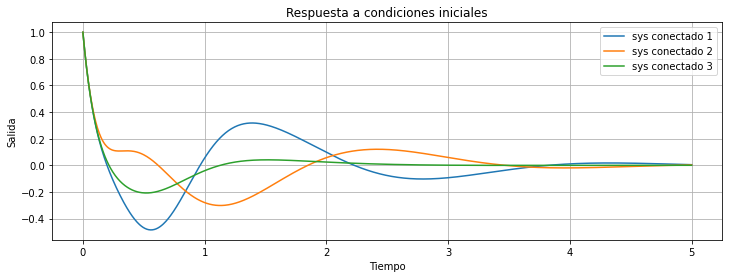

In [46]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t1,y1[0,:],label="sys conectado 1")
ax.plot(t2,y2[0,:],label="sys conectado 2")
ax.plot(t3,y3[0,:],label="sys conectado 3")
plt.legend()
ax.set_title('Respuesta a condiciones iniciales')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Salida")
ax.grid()

Podemos también mirar el esfuerzo de control, ya que es salida de la planta.

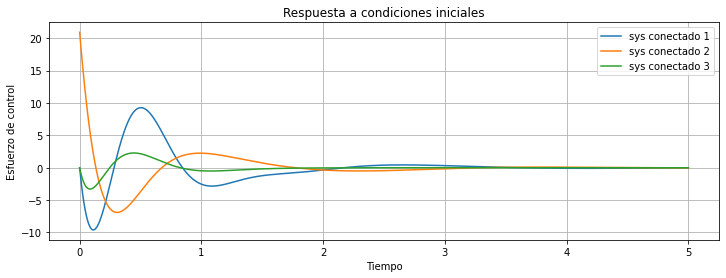

In [47]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t1,y1[1,:],label="sys conectado 1")
ax.plot(t2,y2[1,:],label="sys conectado 2")
ax.plot(t3,y3[1,:],label="sys conectado 3")
plt.legend()
ax.set_title('Respuesta a condiciones iniciales')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Esfuerzo de control")
ax.grid()

Este ejemplo muestra claramente como la elección de los polos usando criterios de optimización como son los de lugar simétrico de las raíces nos da un control mucho mejor, tanto en tiempo de respuesta como en el esfuerzo de control.

In [48]:
psys_controlado_con_ref = ctrl.connect(ctrl.append(sys,Dcr_ref), [[1, 2],[2,1]], [3], [1,2])
psys_controlado_con_ref.pole()

array([-4.242+4.24328128j, -4.242-4.24328128j, -1.04 +2.14j      ,
       -1.04 -2.14j      , -1.42 +0.j        ])

In [49]:

ctrl.dcgain(psys_controlado_con_ref)

array([[ 1.00000000e+00],
       [-5.32907052e-15]])

In [50]:
t,y = ctrl.step_response(psys_controlado_con_ref)

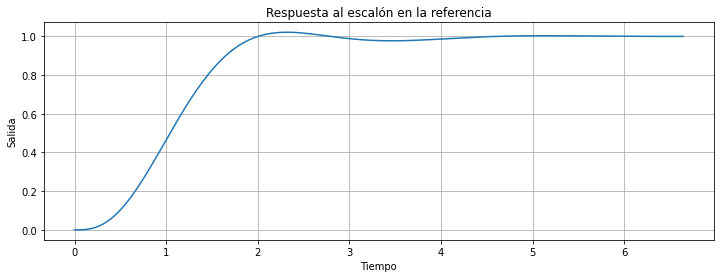

In [51]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,y[0,:].T,label="psys conectado con ref")
ax.set_title('Respuesta al escalón en la referencia')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Salida")
ax.grid()

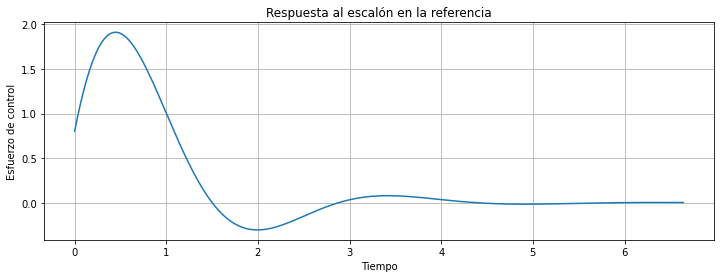

In [52]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,y[1,:].T,label="psys conectado con ref")
ax.set_title('Respuesta al escalón en la referencia')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Esfuerzo de control")
ax.grid()

## Control integral y estimador de orden completo

In [53]:
np.hstack((np.zeros((1,1)), sys.C))
np.hstack((np.zeros((3,1)), sys.A))

array([[  0., -10.,   1.,   0.],
       [  0., -16.,   0.,   1.],
       [  0.,  -0.,   0.,   0.]])

In [54]:
Au=np.vstack((np.hstack((np.zeros((1,1)), sys.C)),
              np.hstack((np.zeros((3,1)), sys.A))))
Au

array([[  0.,   1.,   0.,   0.],
       [  0., -10.,   1.,   0.],
       [  0., -16.,   0.,   1.],
       [  0.,  -0.,   0.,   0.]])

In [55]:
Bu = np.vstack((0,sys.B))
Bu

array([[ 0.],
       [ 0.],
       [ 0.],
       [10.]])

In [56]:
Ku = ctrl.place(Au,Bu, np.array([-1.42, -1.04+2.14j,-1.04-2.14j, -3])) 
Ku

array([[  2.4116712, -29.1264696,   3.81148  ,  -0.35     ]])

In [57]:
Ki=Ku[0,0]
Ki

2.4116711999999563

In [58]:
integrador=ctrl.ss([[0]],[[Ki,-Ki]],[1],[0, 0])
integrador

StateSpace(array([[0.]]), array([[ 2.4116712, -2.4116712]]), array([[1.]]), array([[0., 0.]]))

In [59]:
# Estimado  mas ley de control

L=ctrl.place(sys.A.T, sys.C.T, np.array([-1.42, -1.04+2.14j,-1.04-2.14j])*3).T
L

array([[  0.5     ],
       [ 61.5332  ],
       [217.050408]])

In [60]:
Ae=sys.A-L@sys.C
Ae

array([[ -10.5     ,    1.      ,    0.      ],
       [ -77.5332  ,    0.      ,    1.      ],
       [-217.050408,    0.      ,    0.      ]])

In [61]:
Be=np.hstack((L,sys.B))
Be

array([[  0.5     ,   0.      ],
       [ 61.5332  ,   0.      ],
       [217.050408,  10.      ]])

In [62]:
Ce=-Ku[0:1,1:]
Ce

array([[29.1264696, -3.81148  ,  0.35     ]])

In [63]:
De=0
estim = ctrl.ss(Ae,Be,Ce,0)
estim

StateSpace(array([[ -10.5     ,    1.      ,    0.      ],
       [ -77.5332  ,    0.      ,    1.      ],
       [-217.050408,    0.      ,    0.      ]]), array([[  0.5     ,   0.      ],
       [ 61.5332  ,   0.      ],
       [217.050408,  10.      ]]), array([[29.1264696, -3.81148  ,  0.35     ]]), array([[0., 0.]]))

In [64]:
planta_controlada = ctrl.connect(ctrl.append(sys, estim, integrador), 
                                 [[1,2],[1,3],[2,1],[3,2],[3,3],[5,1]],[4],[1,2,3])
planta_controlada

StateSpace(array([[-10.       ,   1.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ],
       [-16.       ,   0.       ,   1.       ,   0.       ,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , 291.264696 , -38.1148   ,
          3.5      ,  10.       ],
       [  0.5      ,   0.       ,   0.       , -10.5      ,   1.       ,
          0.       ,   0.       ],
       [ 61.5332   ,   0.       ,   0.       , -77.5332   ,   0.       ,
          1.       ,   0.       ],
       [217.050408 ,   0.       ,   0.       ,  74.214288 , -38.1148   ,
          3.5      ,  10.       ],
       [ -2.4116712,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ]]), array([[0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [2.4116712]]), array([[ 1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  

In [65]:
t,y = ctrl.step_response(planta_controlada)

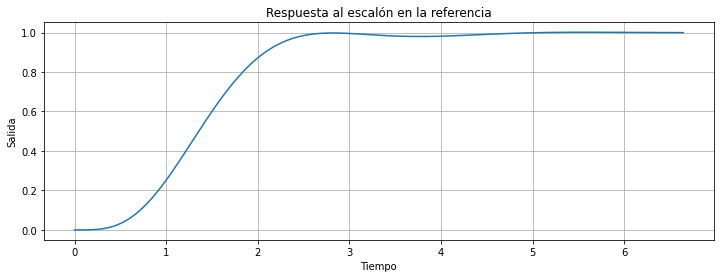

In [66]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,y[0,:].T,label="psys conectado con ref")
ax.set_title('Respuesta al escalón en la referencia')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Salida")
ax.grid()

In [67]:
planta_controlada.pole()

array([-3.12+6.42j, -3.12-6.42j, -1.04+2.14j, -1.04-2.14j, -4.26+0.j  ,
       -3.  +0.j  , -1.42+0.j  ])

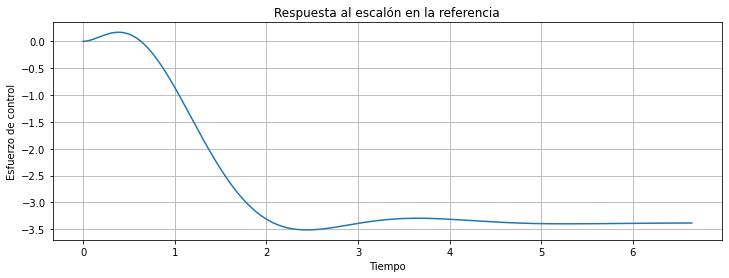

In [68]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,y[1,:].T,label="psys conectado con ref")
ax.set_title('Respuesta al escalón en la referencia')
ax.set_xlabel("Tiempo")
ax.set_ylabel("Esfuerzo de control")
ax.grid()

`